In [15]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [16]:
feature_names = ["thickness_small", "thickness_medium", "thickness_large", "thickness_xlarge",
                 "width_small", "width_medium", "width_large", "width_xlarge",
                 "length_small", "length_medium", "length_large", "length_xlarge"]

class_names = ["6", "8", "9"]

# mapping from feature index to feature name
feature_index_to_name = {i: feature_name for i, feature_name in enumerate(feature_names)}
# mapping from feature name to feature index
feature_name_to_index = {feature_name: i for i, feature_name in enumerate(feature_names)}
# mapping from class index to class name
class_index_to_name = {i: class_name for i, class_name in enumerate(class_names)}
# mapping from class name to class index
class_name_to_index = {class_name: i for i, class_name in enumerate(class_names)}

In [17]:
path_binary = "/Users/gouse/PycharmProjects/AR-Imperial-Thesis/saved/log/leakage_explainer/0628_173016/trees/tree_binary_data.pkl"

path_prob = "/Users/gouse/PycharmProjects/AR-Imperial-Thesis/saved/log/leakage_explainer/0628_173016/trees/tree_prob_data.pkl"

In [18]:
with open(path_binary, 'rb') as f:
    data_binary = pickle.load(f)

X = data_binary['X']
c = data_binary['c']
y = data_binary['y']
tree = data_binary['tree']
paths = data_binary['paths']
path_counts = data_binary['path_counts']
path_classifications = data_binary['path_classifications']
path_indices = data_binary['path_indices']
accuracies = data_binary['accuracies']

with open(path_prob, 'rb') as f:
    data_prob = pickle.load(f)
    
X_prob = data_prob['X']
c_prob = data_prob['c']
y_prob = data_prob['y']
tree_prob = data_prob['tree']
paths_prob = data_prob['paths']
path_counts_prob = data_prob['path_counts']
path_classifications_prob = data_prob['path_classifications']
path_indices_prob = data_prob['path_indices']
accuracies_prob = data_prob['accuracies']


## Number of examples with identical concepts

In [19]:
# fit a decision tree in c and y
from sklearn.tree import DecisionTreeClassifier

c = np.array(c)
y = np.array(y)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(c, y)
y_pred = clf.predict(c)

# print accuracy
accuracy = np.mean(y == y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6324


In [20]:
def find_identical_concepts(X, y, c):
    # Combine X, y, and c into a single DataFrame
    df = pd.DataFrame(index = np.arange(0, X.shape[0]))
    df['class'] = np.array(y)
    c_columns = [f'concept_{i}' for i in range(c.shape[1])]
    df[c_columns] = c
    
    # Group by concepts and count unique classes
    grouped = df.groupby(list(df.columns[1:]))['class'].nunique().reset_index(name='unique_classes')
    
    # Filter to find concept combinations belonging to more than one class
    shared_concepts = grouped[grouped['unique_classes'] > 1]
    
    return grouped, shared_concepts

# Find identical concepts per class
grouped_data, shared_concepts = find_identical_concepts(X, y, c)
print(f"Total unique concept combinations: {len(grouped_data)}")
print(f"Concept combinations with more than one class: {len(shared_concepts)}")

Total unique concept combinations: 64
Concept combinations with more than one class: 57


## Leakage for Decision Paths

In [21]:
paths_prob[3]

[('length_xlarge', '<=', 0.02687594573944807),
 ('length_large', '<=', 0.07450471445918083),
 ('thickness_xlarge', '>', 0.9573398530483246),
 ('width_large', '>', 0.9963947832584381),
 ('length_medium', '>', 0.8444176614284515)]

In [22]:
paths[6]

[('length_xlarge', '<=', 0.5),
 ('length_large', '<=', 0.5),
 ('thickness_xlarge', '>', 0.5),
 ('width_large', '>', 0.5),
 ('length_medium', '>', 0.5)]

In [23]:
def find_shared_and_different_indices(path1_indices, path2_indices):
    set1 = set(path1_indices)
    set2 = set(path2_indices)

    shared_indices = list(set1 & set2)
    different_indices = list(set1 ^ set2)

    return shared_indices, different_indices

binary_indices = path_indices[6]
prob_indices = path_indices_prob[3]

shared_indices, different_indices = find_shared_and_different_indices(binary_indices, prob_indices)
print(len(shared_indices))
print(len(different_indices))
print(len(binary_indices))
print(len(prob_indices))

# SOS! We found that all the indices in binary are also in prob! Great!

# Find the decision paths for the indices of path1 that are not in path2
unique_indices = [i for i in binary_indices if i not in prob_indices]
df_indices = pd.DataFrame(index = np.arange(0, len(unique_indices)))
df_indices['example_idx'] = unique_indices
df_indices['decision_path_idx_in_prob_tree'] = np.nan
df_indices['classification_in_binary_tree'] = np.nan
df_indices['classification_in_prob_tree'] = np.nan
df_indices['true_class'] = [class_index_to_name[cl] for cl in y[unique_indices]]
for idx in unique_indices:
    for path_idx, indices_list in enumerate(path_indices_prob):
        if idx in indices_list:
            df_indices.loc[df_indices['example_idx'] == idx, 'decision_path_idx_in_prob_tree'] = path_idx
            df_indices.loc[df_indices['example_idx'] == idx, 'classification_in_prob_tree'] = class_index_to_name[path_classifications_prob[path_idx]]
            df_indices.loc[df_indices['example_idx'] == idx, 'classification_in_binary_tree'] = class_index_to_name[path_classifications[6]]
      

186
33
219
186


/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_39793/2924816729.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_indices.loc[df_indices['example_idx'] == idx, 'classification_in_prob_tree'] = class_index_to_name[path_classifications_prob[path_idx]]
/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_39793/2924816729.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_indices.loc[df_indices['example_idx'] == idx, 'classification_in_binary_tree'] = class_index_to_name[path_classifications[6]]


## Visualise an example that was misclassified in the binary tree but correctly classified in the prob tree

In [24]:
def convert_to_in_between(decision_path, pr_class):
    conditions = {}
    for feature, op, value in decision_path:
        if feature not in conditions:
            conditions[feature] = {'<=': None, '>': None}
        if value == 0.5:
            if op == '<=':
                conditions[feature]['='] = 0
            elif op == '>':
                conditions[feature]['='] = 1
        else:
            conditions[feature][op] = value

    in_between_clauses = []
    for feature, ops in conditions.items():
        lower = ops['>']
        upper = ops['<=']
        exact = ops.get('=')
        if exact is not None:
            in_between_clauses.append(f"{feature} = {exact}")
        elif lower is not None and upper is not None:
            in_between_clauses.append(f"{feature} in ({lower:.2f}, {upper:.2f})")
        elif lower is not None:
            in_between_clauses.append(f"{feature} > {lower:.2f}")
        elif upper is not None:
            in_between_clauses.append(f"{feature} <= {upper:.2f}")
    
    return " IF " + " AND ".join(in_between_clauses) + f" THEN class = {pr_class}"

[('length_xlarge', '>', 0.02687594573944807), ('length_xlarge', '<=', 0.8820104598999023), ('width_xlarge', '<=', 0.9982125163078308)]
tensor([9.0678e-11, 1.8669e-05, 5.0140e-04, 9.9988e-01, 2.3572e-09, 2.9433e-09,
        9.9966e-01, 1.0578e-04, 2.0867e-05, 9.9978e-01, 3.3211e-05, 7.1187e-01])
{'thickness_small': 0, 'thickness_medium': 1, 'thickness_large': 2, 'thickness_xlarge': 3, 'width_small': 4, 'width_medium': 5, 'width_large': 6, 'width_xlarge': 7, 'length_small': 8, 'length_medium': 9, 'length_large': 10, 'length_xlarge': 11}


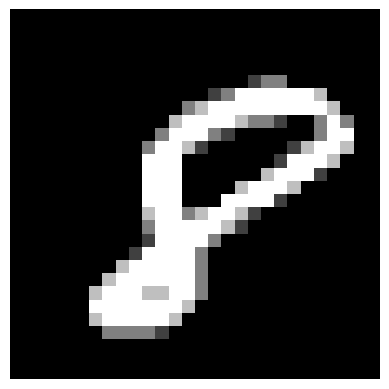

True class: 8

Concept True values:
thickness_small = 0
thickness_medium = 0
thickness_large = 0
thickness_xlarge = 1
width_small = 0
width_medium = 0
width_large = 1
width_xlarge = 0
length_small = 0
length_medium = 1
length_large = 0
length_xlarge = 0

Decision path in ground truth tree: 
  IF length_xlarge = 0 AND length_large = 0 AND thickness_xlarge = 1 AND width_large = 1 AND length_medium = 1 THEN class = 9

Concept Predicted values: 
thickness_small = 0.0000000001
thickness_medium = 0.0000186685
thickness_large = 0.0005014005
thickness_xlarge = 0.9998830557
width_small = 0.0000000024
width_medium = 0.0000000029
width_large = 0.9996578693
width_xlarge = 0.0001057763
length_small = 0.0000208666
length_medium = 0.9997848868
length_large = 0.0000332112
length_xlarge = 0.7118660212

Decision path in leaked tree: 
  IF length_xlarge in (0.03, 0.88) AND width_xlarge <= 1.00 THEN class = 8


In [25]:
# We pick example with index 636 from the df_indices
idx = 636
# Verify that the example belongs to this path
print(paths_prob[6])
print(c_prob[idx, :])
print(feature_name_to_index)

# plot the digit
plt.imshow(X_prob[idx].reshape(28,28), cmap='gray')
plt.axis('off')
plt.show()
print(f"True class: {class_index_to_name[y_prob[idx].item()]}\n")

print(f"Concept True values:")
for concept in range(c.shape[1]):
    print(f"{feature_index_to_name[concept]} = {int(c[idx, concept])}")

pr_class = class_index_to_name[path_classifications[6]]    
print(f"\nDecision path in ground truth tree: ")
print(f" {convert_to_in_between(paths[6], pr_class)}")

print(f"\nConcept Predicted values: ")
for concept in range(c_prob.shape[1]):
    print(f"{feature_index_to_name[concept]} = {c_prob[idx, concept]:.10f}")

pr_class = class_index_to_name[path_classifications_prob[6]]
print(f"\nDecision path in leaked tree: ")
print(f" {convert_to_in_between(paths_prob[6], pr_class)}")

## Make Box Plots

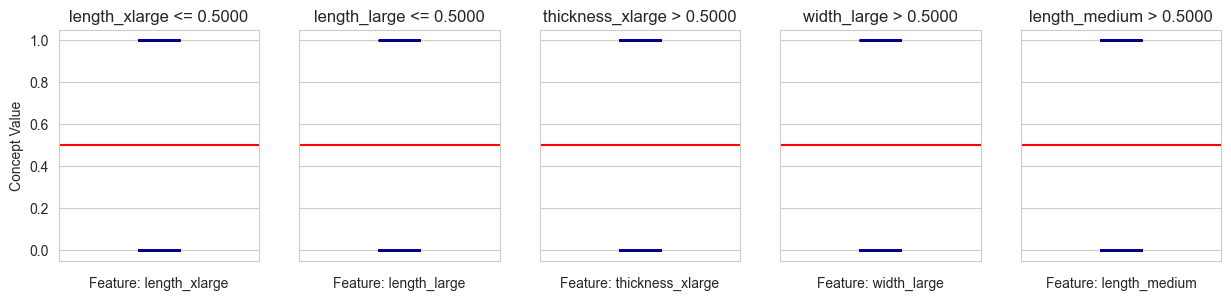

<Figure size 2000x500 with 0 Axes>

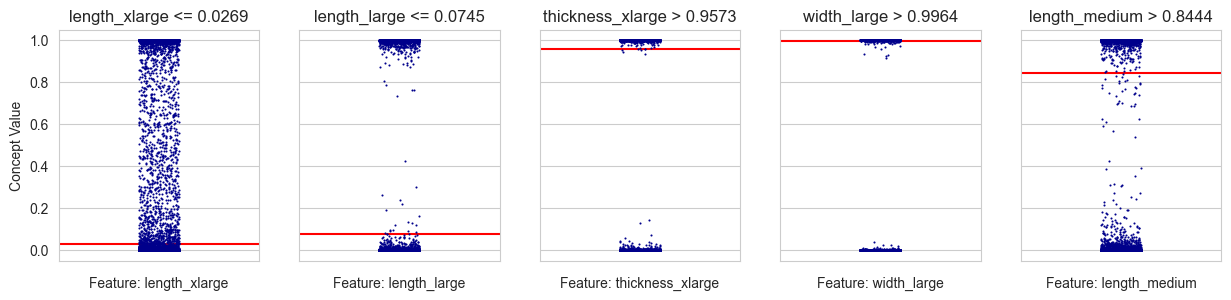

<Figure size 2000x500 with 0 Axes>

In [26]:
def plot_boxplots_for_path(c, paths, feature_names):

    fig, axs = plt.subplots(1, len(paths), figsize=(3* len(paths), 3), sharey=True)
    
    if len(paths) == 1:
        axs = [axs]
    plt.figure(figsize=(20, 1 * len(paths)))
    for i, (feature, op, threshold) in enumerate(paths):
        feature_index = feature_names[feature]
        sns.stripplot(y=c[:, feature_index], ax=axs[i], color='darkblue', jitter=True, size=1.5)
        axs[i].axhline(y=threshold, color='r', linestyle='-')
        axs[i].set_title(f"{feature} {op} {threshold:.4f}")
        axs[i].set_ylabel('Concept Value')
        axs[i].set_xlabel(f'Feature: {feature}')
    plt.tight_layout()
    plt.show()
    
# Plot boxplots for path with id=6
# extract feature names for this path
feature_names_reduced = [f_n for f_n, _, _ in paths_prob[3]]
feature_thres = [thres for _, _, thres in paths_prob[3]]
feature_ids = [feature_name_to_index[f_n] for f_n in feature_names_reduced]

plot_boxplots_for_path(c, paths[6], feature_name_to_index)
plot_boxplots_for_path(c_prob, paths_prob[3], feature_name_to_index)

## Plot the decision trees

In [27]:
from sklearn.tree import export_graphviz
import graphviz

def modify_thresholds(clf):
    for i in range(clf.tree_.node_count):
        if clf.tree_.threshold[i] <= 0.5:
            clf.tree_.threshold[i] = -2

# Assume clf is your trained decision tree classifier
modify_thresholds(tree)

In [32]:
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=feature_names,  
                           class_names=class_names,  
                           filled=True, rounded=True,  
                           special_characters=True)
dot_data = dot_data.replace('&le; -2', '= 0 ')
dot_data = dot_data.replace(' .0', '')

graph = graphviz.Source(dot_data)
graph.render("./plots/binary_decision_tree", format="png", cleanup=True)

'plots/binary_decision_tree.png'

In [34]:
dot_data = export_graphviz(tree_prob, out_file=None, 
                           feature_names=feature_names,  
                           class_names=class_names,  
                           filled=True, rounded=True,  
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("./plots/prob_decision_tree", format="png", cleanup=True)

'plots/prob_decision_tree.png'